# Outline

- create a model that predicts the category of each article by **Self-Attention** mechanism
- train data is `matichon.json` that contains about 17K articles of Thai news by Matichon between 2015-2018
- X is `article` of news (limit first 500 tokens)
- y is category (10 labels)
- F1 score of Logistic Regression using article : **0.81**

# Import

In [1]:
import pandas as pd
import numpy as np
import re, emoji, urllib, html

from keras.layers import Dense, Input, Embedding, Attention, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.models import Model
from keras.utils import plot_model, to_categorical, pad_sequences

from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from pythainlp.tokenize import word_tokenize

- custom tokenization function
- remove all quotations and shrink newlines `\n` and white spaces 

In [2]:
def my_tokenize(text):
    ### REMOVE URL ###
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    ### REMOVE EMOJI ###
    text = emoji.replace_emoji(text) # remove emoji
    ### REPLACE ###
    text = re.sub(r'[“”„\"]', '', text) # remove double quotations
    text = re.sub(r'[‘’′′′′`\']', '', text) # remove single quotations
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'เเ', 'แ', text)
    ### SHRINK SOME REDUPLICATION ###
    text = re.sub(r'าา+', 'า', text)
    text = re.sub(r'ยย+', 'ย', text)
    text = re.sub(r'ๆๆ+', 'ๆ', text)
    text = re.sub(r'ะะ+', 'ะ', text)
    ### am ###
    text = re.sub(r'ํา','ำ', text) # o + า -> ำ
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text) # am + tone -> tone + am
    ### TOKENIZE AND FILTERING ###
    tokens = word_tokenize(text, keep_whitespace=False)
    tokens = [token.strip('(').strip(')') for token in tokens]
    tokens = [token for token in tokens if re.match(r'[A-zก-ไ][A-zก-๙\.]*', token)]
    return tokens

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [3]:
## load pre-trained word vector
wv_model = Word2Vec.load("data/word2vec_matichon.model")

## load matichon news data
## drop "date", "headline", "url", and "id"
df = pd.read_json('data/matichon.json')
df.drop(columns=['date','headline','url','id'], inplace=True)

df

,article,category
0,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign
1,"""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics
2,แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment
3,กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment
4,แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment
...,...,...
17104,เมื่อวันที่ 5 ก.ค. ที่ สน.พญาไท น.ส.ณัฏฐา มหัท...,politics
17105,วันที่ 5 กรกฎาคม เจ้าหน้าที่ขุดทางระบายน้ำที่ด...,region
17106,"สนช.ผ่าน พ.ร.บ.สงฆ์ 3 วาระรวด ""วิษณุ"" แจงสาระส...",politics
17107,หมายเหตุ – จากกรณีที่ กระทรวงศึกษาธิการ (ศธ.) ...,education


In [4]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

# Preprocessing

### tokenize

- it may take more than 2 minutes
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`
- limit first 500 tokens 

In [5]:
df['tokens'] = df['article'].apply(my_tokenize)
df.head()

,article,category,tokens
0,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign,"[ธ.ค., หนังสือพิมพ์, อัล, ริยาด, ของ, ทางการ, ..."
1,"""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics,"[บิ๊ก, ป้อม, แจง, ครม., มี, ความพยายาม, ยุยง, ..."
2,แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment,"[แม้, จะ, ทำหน้าที่, ภรรยา, ที่, ดี, มา, เฝ้า,..."
3,กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment,"[กลายเป็น, ดารา, หนุ่ม, เนื้อ, หอม, แฟนคลับ, แ..."
4,แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment,"[แสดง, ดี, จน, เป็นที่, ถูกอกถูกใจ, แฟนคลับ, จ..."


In [6]:
df['tokens'] = df['tokens'].apply(lambda x: x[:500])

## check min, mean, max length of tokens
df['tokens'].apply(len).describe()

count    17109.000000
mean       304.446958
std        134.532382
min         20.000000
25%        197.000000
50%        290.000000
75%        426.000000
max        500.000000
Name: tokens, dtype: float64

### indexing & one-hot-encoding

- indexing(label encoding) is a process to convert categorical data into numerical form
~~~python
vocab : {'อร่อย':0, 'ไทย':1,...}
y : {'crime':0, 'economy':1,...}
~~~

- one-hot-encoding is also required for `y` to pass to a NN model

In [7]:
## make vocaburary list
all_vocabs = sorted(set.union(*df['tokens'].apply(set)))
print('total vocab in headline :', len(all_vocabs))

## indexing for vocab
vocab2index = {'<PADDING>':0} # special symbol for padding and EoS
for i, vocab in enumerate(all_vocabs):
    vocab2index[vocab] = len(vocab2index)

## label encoding for y
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df['category'])

## one-hot-encoding
y = to_categorical(y, num_classes=len(y_encoder.classes_))

total vocab in headline : 53863


### create `X` sequence and train-test splitting

- max length = 500

In [8]:
MAX_LENGTH = 500

X = [[vocab2index[token] for token in tokens] for tokens in df['tokens']]
X = pad_sequences(X, maxlen=MAX_LENGTH, padding="post")

X

array([[24440, 40688, 42738, ...,     0,     0,     0],
       [26789, 28529, 50164, ...,     0,     0,     0],
       [51069, 18105, 23884, ..., 39020, 36447, 21361],
       ...,
       [38347, 29263, 29481, ..., 53403, 23884, 52908],
       [40989, 18268, 11996, ..., 53530, 50576, 37448],
       [47889, 36794, 11980, ...,     0,     0,     0]], dtype=int32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['category'], random_state=42)

print('TRAIN:', X_train.shape, y_train.shape)
print('TEST :', X_test.shape, y_test.shape)

TRAIN: (13687, 500) (13687, 10)
TEST : (3422, 500) (3422, 10)


In [10]:
## how to inverse
y_encoder.inverse_transform(np.argmax(y_train, axis=1))

array(['entertainment', 'crime', 'politics', ..., 'politics', 'politics',
       'politics'], dtype=object)

# Modelling

### create LSTM model

In [11]:
## constants
VOCAB_SIZE = len(vocab2index)
EMBEDDING_DIM = 256
HIDDEN_DIM = 128

def make_model():
    ## Make Model with Functional API
    ## Define Layers
    input_layer = Input(shape=(X_train.shape[-1],), name='Input')
    embedding = Embedding(input_dim=VOCAB_SIZE,
                        input_length=X_train.shape[-1],
                        output_dim=EMBEDDING_DIM,
                        mask_zero=True, # let LSTM ignore padding
                        name = 'Embedding')
    batch_norm = BatchNormalization(name='BatchNorm')
    attention = Attention(name='SelfAttn')
    attention_out = Dense(HIDDEN_DIM, activation='relu', name='SelfAttn_out')
    max_pool = GlobalMaxPool1D(name='MaxPool')
    hidden = Dense(HIDDEN_DIM, activation='relu', name='Hidden')
    dropout = Dropout(0.2, name='Dropout')
    output_layer = Dense(y_train.shape[-1], activation='softmax', name='Output')

    ## Build Model
    x = embedding(input_layer)
    x = batch_norm(x)
    x = attention([x, x])
    x = attention_out(x)
    x = max_pool(x)
    x = hidden(x)
    x = dropout(x)
    x = output_layer(x)

    model = Model(inputs=[input_layer], outputs=[x])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 500)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 500, 256)             1378918   ['Input[0][0]']               
                                                          4                                       
                                                                                                  
 BatchNorm (BatchNormalizat  (None, 500, 256)             1024      ['Embedding[0][0]']           
 ion)                                                                                             
                                                                                              

2023-11-03 10:30:17.784713: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-03 10:30:17.784734: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-03 10:30:17.784739: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-03 10:30:17.784934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-03 10:30:17.784950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


None


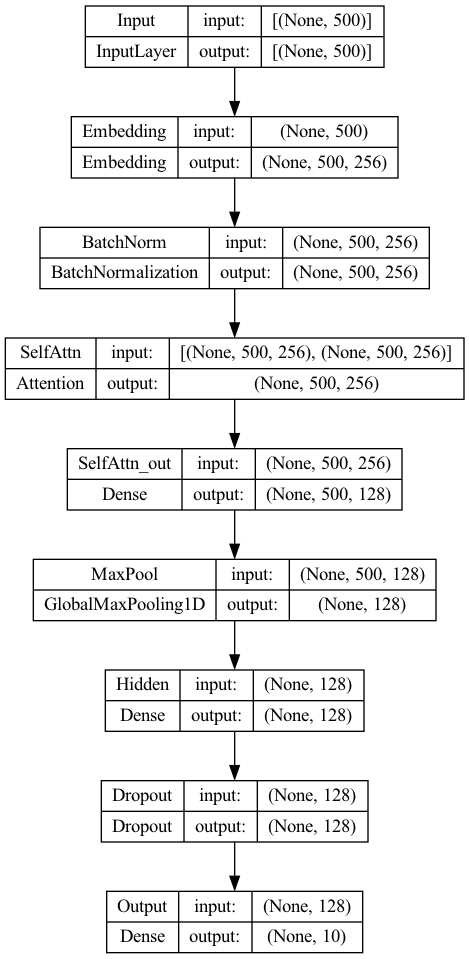

In [12]:
model = make_model()

## number of parameters
print(model.summary())

## plot model (save as model.png)
plot_model(model, show_shapes=True)

### fit model

In [13]:
## fit
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

Epoch 1/10


2023-11-03 10:30:18.716482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-03 10:30:18.757167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


86/86 [==============================] - 17s 183ms/step - loss: 1.3450 - accuracy: 0.5673 - val_loss: 2.3013 - val_accuracy: 0.0935
Epoch 2/10
86/86 [==============================] - 16s 186ms/step - loss: 0.7745 - accuracy: 0.7392 - val_loss: 2.2770 - val_accuracy: 0.3346
Epoch 3/10
86/86 [==============================] - 18s 209ms/step - loss: 0.5713 - accuracy: 0.8058 - val_loss: 1.7766 - val_accuracy: 0.7049
Epoch 4/10
86/86 [==============================] - 20s 232ms/step - loss: 0.4397 - accuracy: 0.8456 - val_loss: 1.1139 - val_accuracy: 0.7429
Epoch 5/10
86/86 [==============================] - 21s 239ms/step - loss: 0.3260 - accuracy: 0.8821 - val_loss: 0.8003 - val_accuracy: 0.7542
Epoch 6/10
86/86 [==============================] - 22s 257ms/step - loss: 0.2451 - accuracy: 0.9117 - val_loss: 0.7219 - val_accuracy: 0.7465
Epoch 7/10
86/86 [==============================] - 22s 258ms/step - loss: 0.1815 - accuracy: 0.9375 - val_loss: 0.8110 - val_accuracy: 0.7348
Epoch 8/10

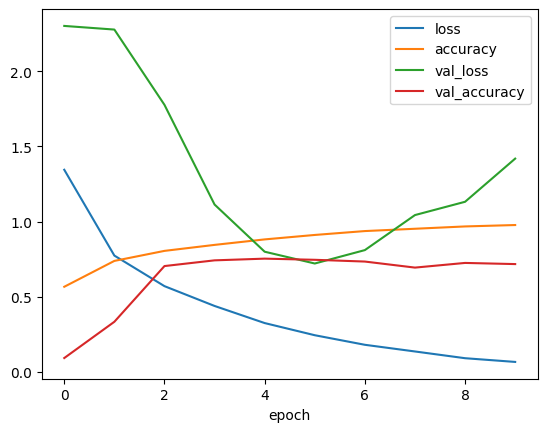

In [14]:
pd.DataFrame(history.history).plot(xlabel='epoch');

- validation loss increased = overfitting
- epoch 4-5 is enough

# Evaluate and re-train

2023-11-03 10:33:39.902688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


107/107 [==============================] - 2s 18ms/step
               precision    recall  f1-score   support

        crime       0.64      0.68      0.66       428
      economy       0.70      0.71      0.71       250
    education       0.67      0.77      0.72       211
entertainment       0.92      0.76      0.83       185
      foreign       0.89      0.88      0.88       266
        local       0.48      0.26      0.33       388
     politics       0.68      0.91      0.78       627
    publicize       0.82      0.61      0.70       296
       region       0.61      0.66      0.64       531
        sport       0.93      0.88      0.91       240

     accuracy                           0.71      3422
    macro avg       0.73      0.71      0.72      3422
 weighted avg       0.70      0.71      0.70      3422



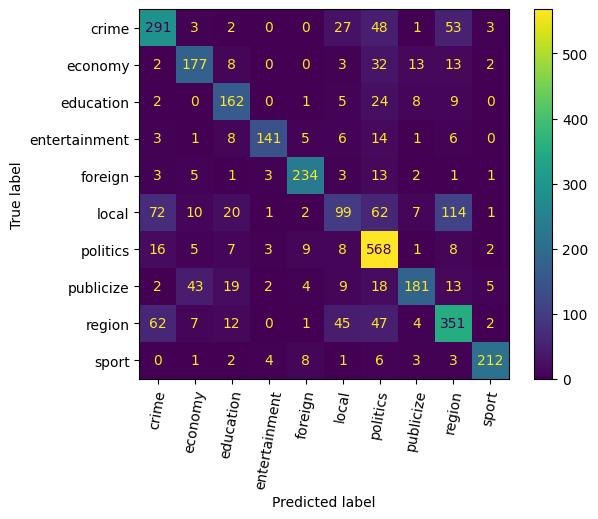

In [15]:
## predict
y_pred = y_encoder.inverse_transform(model.predict(X_test).argmax(axis=1))
y_true = y_encoder.inverse_transform(y_test.argmax(axis=1))

## print F1 scores
print(classification_report(y_true, y_pred))

## confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(xticks_rotation=80);

### re-train with epoch=5

Epoch 1/5
86/86 [==============================] - 26s 265ms/step - loss: 1.3552 - accuracy: 0.5731 - val_loss: 2.2990 - val_accuracy: 0.1271
Epoch 2/5
86/86 [==============================] - 21s 243ms/step - loss: 0.7399 - accuracy: 0.7494 - val_loss: 2.2739 - val_accuracy: 0.3762
Epoch 3/5
86/86 [==============================] - 23s 263ms/step - loss: 0.5326 - accuracy: 0.8144 - val_loss: 1.7824 - val_accuracy: 0.7159
Epoch 4/5
86/86 [==============================] - 21s 248ms/step - loss: 0.4017 - accuracy: 0.8598 - val_loss: 1.0840 - val_accuracy: 0.7370
Epoch 5/5
  1/107 [..............................] - ETA: 23s

2023-11-03 10:35:33.894954: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


107/107 [==============================] - 2s 19ms/step
               precision    recall  f1-score   support

        crime       0.72      0.47      0.57       428
      economy       0.76      0.67      0.71       250
    education       0.68      0.84      0.76       211
entertainment       0.90      0.83      0.87       185
      foreign       0.94      0.85      0.89       266
        local       0.41      0.38      0.39       388
     politics       0.81      0.87      0.84       627
    publicize       0.75      0.75      0.75       296
       region       0.58      0.75      0.66       531
        sport       0.93      0.92      0.93       240

     accuracy                           0.72      3422
    macro avg       0.75      0.73      0.74      3422
 weighted avg       0.72      0.72      0.72      3422



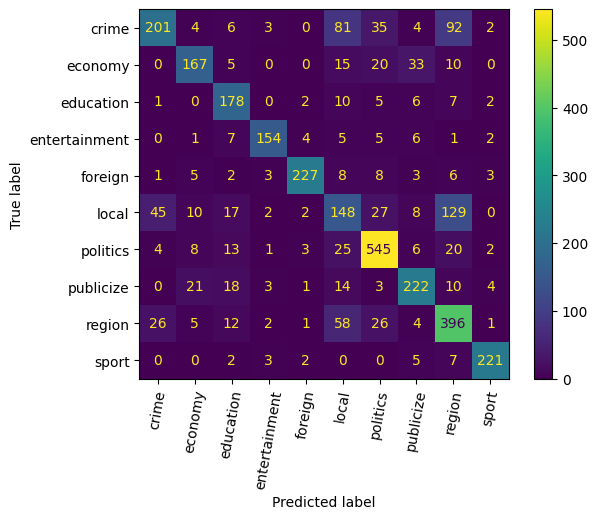

In [16]:
## compile model again
model2 = make_model()

## fit
history = model2.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=128)

## predict
y_pred = y_encoder.inverse_transform(model2.predict(X_test).argmax(axis=1))
y_true = y_encoder.inverse_transform(y_test.argmax(axis=1))

## print F1 scores
print(classification_report(y_true, y_pred))

## confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(xticks_rotation=80);